In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

     |████████████████████████████████| 1.9 MB 13.9 MB/s 
     |████████████████████████████████| 462 kB 62.3 MB/s 
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-o5x35jgs/pafy_aa219debb83f47b69aa76cba2a4e61cd
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-o5x35jgs/pafy_aa219debb83f47b69aa76cba2a4e61cd
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35706 sha256=1250a22f7fc1e77a6ecb3891b686ab44a6769b19d6f295936d1e3cdc4f2c8331
  Stored in directory: /tmp/pip-ephem-wheel-cache-xn80p7v4/wheels/64/82/dd/3d7823b3bbbe1aca9b30f8cf0d6bb6c1b72ccd95e3360f8190
Successfully built pafy


In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2859008/45929032 bytes (6.2%)6135808/45929032 bytes (13.4%)9306112/45929032 bytes (20.3%)12345344/45929032 bytes (26.9%)15220736/45929032 bytes (33.1%)18505728/45929032 bytes (40.3%)21733376/45929032 bytes (47.3%)24854528/45929032 bytes (54.1%)27459584/45929032 bytes (59.8%)30236672/45929032 bytes (65.8%)32538624/45929032 bytes (70.8%)34660352/45929032 bytes (75.5%)

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

boxing
handclapping
running
walking
handwaving
jogging


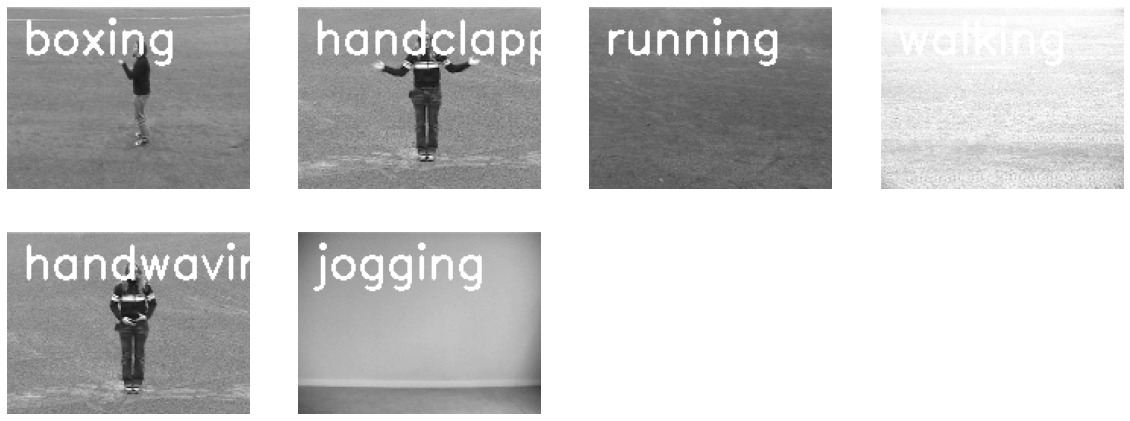

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/drive/MyDrive/3rd Year/ML/Human-Action-Recognition-KTH-master/dataset')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
    print(selected_class_Name)
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/3rd Year/ML/Human-Action-Recognition-KTH-master/dataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/3rd Year/ML/Human-Action-Recognition-KTH-master/dataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 60, 60

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 40

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/3rd Year/ML/Human-Action-Recognition-KTH-master/dataset/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["boxing", "handclapping", "handwaving", "jogging","running","walking"]

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: boxing
Extracting Data of Class: handclapping
Extracting Data of Class: handwaving
Extracting Data of Class: jogging
Extracting Data of Class: running
Extracting Data of Class: walking


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.20, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

In [13]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))


    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [25]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 40, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 40, 15, 15, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 40, 15, 15, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 40, 15, 15, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 40, 5, 5, 32)    

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

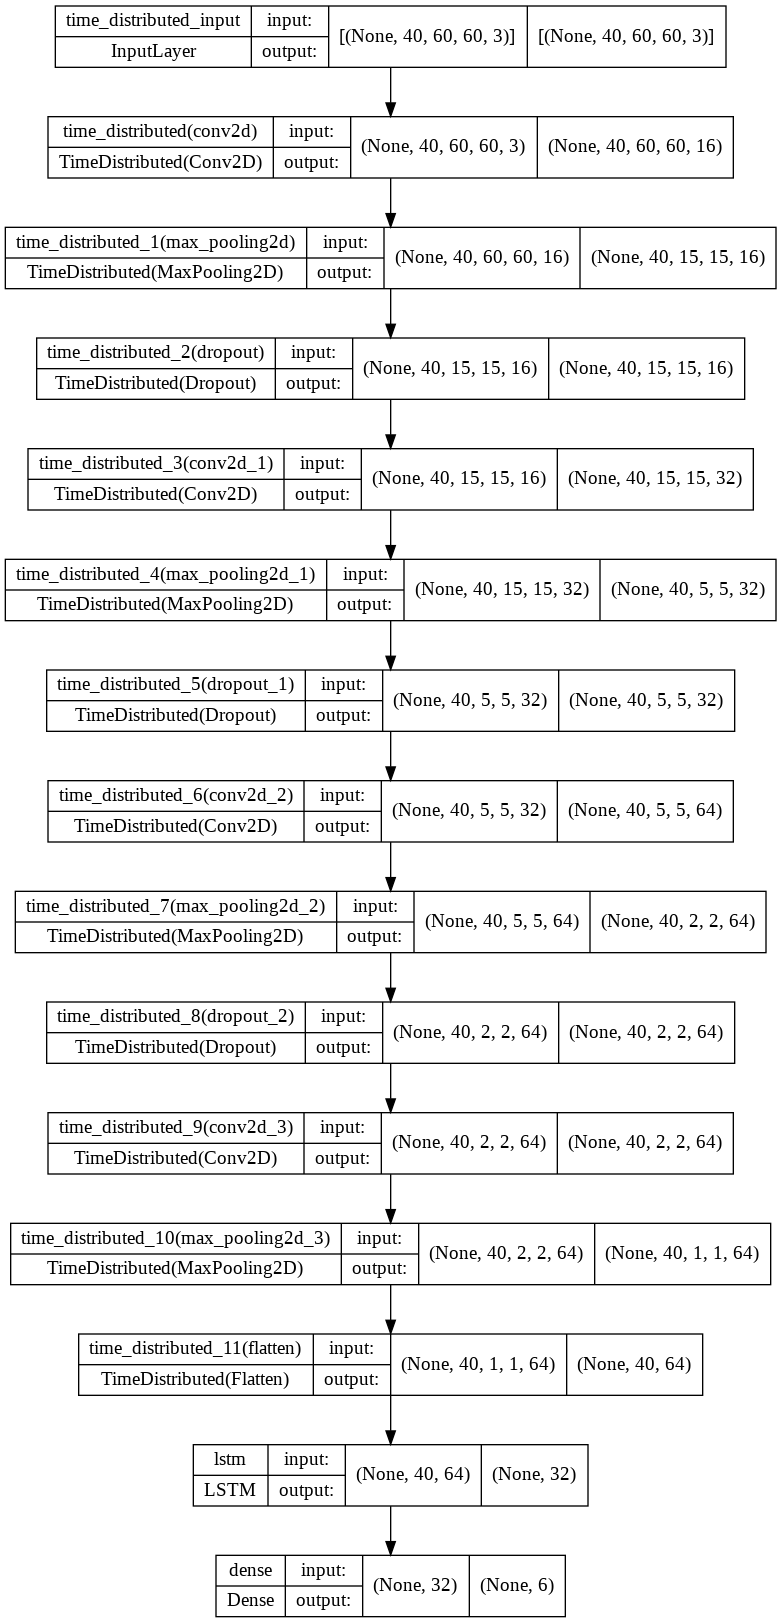

In [15]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [15]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


In [16]:
model = KerasClassifier(build_fn=create_LRCN_model, batch_size=4, epochs=70,verbose=1)


In [17]:

param_grid = dict()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(features_train, labels_train)


In [26]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 80, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/80
96/96 [==============================] - 35s 335ms/step - loss: 1.8060 - accuracy: 0.1571 - val_loss: 1.7984 - val_accuracy: 0.1250
Epoch 2/80
96/96 [==============================] - 30s 313ms/step - loss: 1.7949 - accuracy: 0.1597 - val_loss: 1.8017 - val_accuracy: 0.1250
Epoch 3/80
96/96 [==============================] - 30s 310ms/step - loss: 1.7938 - accuracy: 0.1885 - val_loss: 1.7980 - val_accuracy: 0.1250
Epoch 4/80
96/96 [==============================] - 30s 311ms/step - loss: 1.7415 - accuracy: 0.2225 - val_loss: 1.3917 - val_accuracy: 0.3438
Epoch 5/80
96/96 [==============================] - 30s 310ms/step - loss: 1.3636 - accuracy: 0.3220 - val_loss: 1.1629 - val_accuracy: 0.3854
Epoch 6/80
96/96 [==============================] - 29s 307ms/step - loss: 1.1468 - accuracy: 0.3351 - val_loss: 1.1512 - val_accuracy: 0.3021
Epoch 7/80
96/96 [==============================] - 30s 309ms/step - loss: 1.1768 - accuracy: 0.3953 - val_loss: 1.1218 - val_accuracy: 0.3438

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [27]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 4s 689ms/step - loss: 0.6015 - accuracy: 0.7833


In [45]:
from sklearn.metrics import classification_report
y_pred=LRCN_model.predict(features_test,batch_size=64,verbose=1)
y_pred_bool=np.argmax(y_pred,axis=1)
x_test=np.argmax(labels_test,axis=1)
print(classification_report(x_test,y_pred_bool))

2/2 [==============================] - 4s 2s/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.85      0.94      0.89        18
           2       0.93      0.74      0.82        19
           3       0.50      0.55      0.52        20
           4       0.61      0.92      0.73        12
           5       0.90      0.64      0.75        28

    accuracy                           0.78       120
   macro avg       0.79      0.80      0.78       120
weighted avg       0.81      0.78      0.78       120



#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [30]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


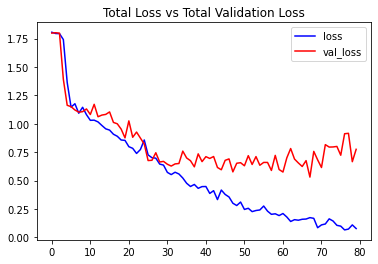

In [31]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

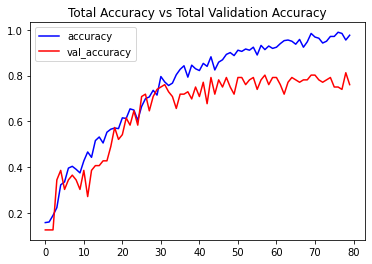

In [32]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

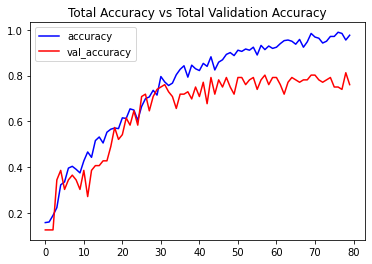

In [36]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')